In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpContinuous, PULP_CBC_CMD
import numpy as np

In [7]:

print("EVCS placement optimisation model with the objective to minimise the total operational cost")

EVCS placement optimisation model with the objective to minimise the total operational cost


In [8]:

# Read data
network_df = pd.read_csv('data/network.csv')

# Read data
demand_df = pd.read_csv('data/ev_demand.csv')


print(network_df.head())
print(demand_df.head())

   Link  From  To  Capacity  Distance
0     1     1   2      1500         6
1     2     1   3      1500         4
2     3     2   1      1500         6
3     4     2   6      1500         5
4     5     3   1      1500         4
   Node  EV demand
0     1         11
1     2         14
2     3         10
3     4         15
4     5         12


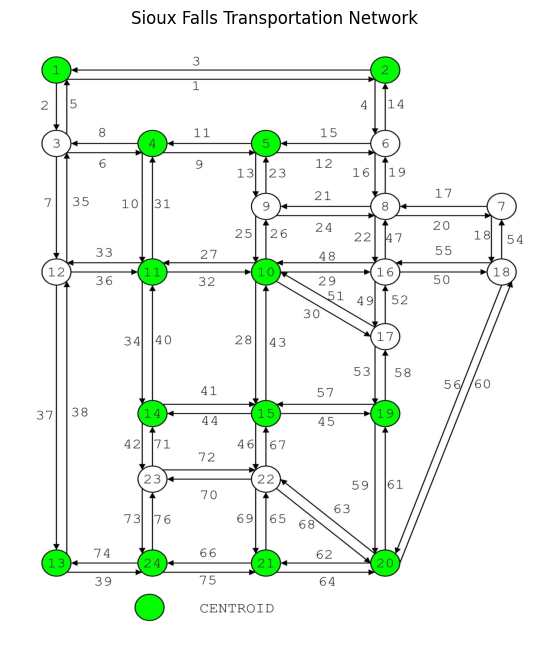

In [9]:
img = Image.open("data/Sioux-Falls-Network.jpg")
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Sioux Falls Transportation Network")
plt.show()

In [10]:
# node list
nodes = sorted(set(network_df['From']).union(network_df['To']))

# Demand 
demand = dict(zip(demand_df['Node'], demand_df['EV demand']))
for n in nodes:
    demand.setdefault(n, 0)

# Symmetric distance matrix
dist_matrix = {(row['From'], row['To']): row['Distance'] for _, row in network_df.iterrows()}
for i, j in list(dist_matrix):
    dist_matrix[(j, i)] = dist_matrix[(i, j)]

# Parameters
coverage_radius = 20
max_stations = 10
station_cost = 1000
per_km_cost = 2


model = LpProblem("EVCS_Operational_Cost_Minimisation", LpMinimize)


x = {j: LpVariable(f"x_{j}", cat=LpBinary) for j in nodes}
y = {
    (i, j): LpVariable(f"y_{i}_{j}", lowBound=0, cat=LpContinuous)
    for i in nodes for j in nodes
    if (i, j) in dist_matrix and dist_matrix[i, j] <= coverage_radius
}


model += (
    lpSum(x[j] * station_cost for j in nodes) +
    lpSum(y[i, j] * dist_matrix[i, j] * per_km_cost for (i, j) in y)
)


for i in nodes:
    model += lpSum(y[i, j] for j in nodes if (i, j) in y) == demand[i]


for (i, j) in y:
    model += y[i, j] <= demand[i] * x[j]


model += lpSum(x[j] for j in nodes) <= max_stations


model.solve(PULP_CBC_CMD(msg=1))

# Results
selected_stations = [j for j in nodes if x[j].varValue > 0.5]
assignments = [(i, j, y[i, j].varValue) for (i, j) in y if y[i, j].varValue > 0.01]

print("\n🚉 Selected EVCS Locations:")
print(selected_stations)

print("\n🔌 Demand Assignments (i → j):")
for i, j, amt in assignments:
    if x[j].varValue < 0.5:
        print(f"⚠️  ERROR: Assigned demand to node {j}, which has no station!")
    print(f"  Node {i} → Charging Station {j}: {amt:.1f} units")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/masoodiota/miniforge3/envs/paper3/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/7a4e7c49d5fa465ba3b34611973137b8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/7a4e7c49d5fa465ba3b34611973137b8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 106 COLUMNS
At line 507 RHS
At line 609 BOUNDS
At line 634 ENDATA
Problem MODEL has 101 rows, 100 columns and 252 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9787.5 - 0.00 seconds
Cgl0004I processed model has 97 rows, 96 columns (24 integer (24 of which binary)) and 244 elements
Cbc0038I Initial state - 14 integers unsatisfied sum - 4.75
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 10040 iterations 31
Cbc0038I Solution found of 10040
Cbc0038I Relaxing continuous gives 10026
Cbc0038I Before 